<a href="https://colab.research.google.com/github/oliverob/quantum/blob/master/qgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Generative Adversarial Network (qGAN)

Loading an arbitary random probability distribution into a n qubit quantum state normally requires $O(2^n)$ gates which in most algorithms will dominate the complexity of the quantum algorithm and make it useless. By using a qGAN this loading can be done in $O(poly(n))$ gates [[1](https://https://www.nature.com/articles/s41534-019-0223-2)]. 

A qGAN is a version of a [Generative Adversarial Network](https://papers.nips.cc/paper/5423-generative-adversarial-nets) with a quantum generator and a classical discriminator. The quantum generator is trained to transform a given n-qubit input into:
$$
\sum_{j=0}^{2^n-1} \sqrt{p^j_{\theta}}\left| j \right\rangle
$$
where $p^j_{\theta}$ relate to the probabilty of the state $j$. The discriminator has to try and distinguish between the output of the generator and the training data set. The two networks train alternatively and will eventaully reach a nash equilibrium where the discriminator cannot tell apart the generator and the training set data. The aim of this process is for $p^j_{\theta}$ to approximate the distribution of the training data.

This tutorial will guide you through using a qGAN to load a lognormal distribution to a 2 qubit system.

# Setup

In [ ]:
!pip install --upgrade tensorflow==2.1.0  tensorflow-quantum tensorflow-gan tensorflow-probability==0.9 tensorflow-datasets

In [31]:
import tensorflow as tf
import tensorflow_quantum as tfq
import tensorflow_gan as tfg

import cirq
import sympy
import numpy as np
import collections
import math

import matplotlib.pyplot as plt

# Intialise qubits
num_qubits = 2 #@param
qubits = [cirq.GridQubit(x,0) for x in range(num_qubits)]


# Load Training Data

Before building the model, you need to generate the training data set.

In [26]:
def generate_data():
  """Generate training data for discriminator
     
     Bundles this with noise for generator to use
  """

  size = 1000 # Size of training data set

  # Take samples of lognormal distribution with mean = 1 and standard deviation =1
  mu =1
  sigma =1
  continous_data = np.random.lognormal(mean=mu, sigma=sigma, size=size)
  
  # Remove all samples that lie outside the range expressible in the given number of qubits
  continous_data = continous_data[continous_data <= 2**num_qubits-0.5]

  # Discretize the remaining samples so the continous distribution can be approximated by a discrete distribution
  discrete_data = tf.convert_to_tensor(np.digitize(continous_data,[i - 0.5 for i in range(1,2**num_qubits)]),dtype=tf.dtypes.int32)

  # Convert the decimal into binary tensor
  discrete_data = tf.cast(tf.math.mod(tf.bitwise.right_shift(tf.expand_dims(discrete_data,1), tf.range(num_qubits)), 2),dtype=tf.float32)
  
  # Intialise the same number of circuits as the discrete tensor to a uniform distribution by applying multiple hardardman gates
  noise = []
  for n in range(discrete_data.shape[0]):
      noise.append(cirq.Circuit(cirq.Moment(cirq.H.on_each(qubits))))
  noise = tfq.convert_to_tensor(noise)

  return noise, discrete_data



# Quantum Generator


Each layer of a quantum generator consists of a layer of parameterised $R_y$ rotations, and a layer of $CZ$ gates to entangle all the qubits.

The quantum generator you will be using only is only one layer deep. To represent more complex structures a larger circuit depth would need to be used.

In [27]:
def quantum_generator_model(initial_distribution_tensor):
  # Create parameters for each qubit
  theta = sympy.symbols('a0:%d'%num_qubits)

  # Set the input to the network
  inputs = tf.keras.Input(shape=(),dtype=tf.dtypes.string)

  # Create the parameterised Ry rotation layer circuit
  parameterized_circuit = cirq.Circuit(cirq.Moment([cirq.ry(theta[i])(qubits[i]) for i in range(num_qubits)]))

  # Entangle all the qubits by applying CZ in a circular fashion - except when there are only two qubits and then just apply one CZ
  entangle_circuit = cirq.Circuit()
  if(num_qubits > 2):
    for i in range(num_qubits):
      entangle_circuit.append([cirq.CZ(qubits[i], qubits[(i + 1) % num_qubits])])
  else:
    entangle_circuit.append([cirq.CZ(qubits[0],qubits[1])])
  
  # Combine the parameterized circuit layer and the entanglement circuit layer
  layer_circuit =  parameterized_circuit + entangle_circuit
  print(layer_circuit)

  # Add this circuit layer to the network with an output on measurements on in the Z component
  # Manipulate the output so it maps the -1, 1 outputs to 0, 1 like the binary discrete data generated by generate_data
  layer = tfq.layers.PQC(layer_circuit, [(cirq.Z(qubits[i])+1)/2 for i in range(num_qubits)], repetitions=1)(inputs) #Important to have repetition =1
  model = tf.keras.Model(inputs=[inputs], outputs=[layer])

  #model.summary()

  return model(initial_distribution_tensor)

# Test the quantum generator
noise, real_data = generate_data()
print(quantum_generator_model(noise))
print(real_data)

(0, 0): ───Ry(a0)───@───────@───
                    │       │
(1, 0): ───Ry(a1)───@───@───┼───
                        │   │
(2, 0): ───Ry(a2)───────@───@───
tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]], shape=(856, 3), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 1. 0.]], shape=(856, 3), dtype=float32)


## Generator Loss Function

In [19]:
def generator_loss_function(gan_model):
  # Function from https://www.nature.com/articles/s41534-019-0223-2
  m = gan_model.discriminator_gen_outputs.shape[0]
  sum = tf.math.reduce_sum(tf.math.log(gan_model.discriminator_gen_outputs))
  sum = 1/m * sum
  return sum

# Discriminator

The discriminator is a classical neural network. You will use a 3-layer network with 50 input nodes, 20 hidden nodes and 1 output nodes. The structure of the discriminator is picked so it is equally balanced with the generator by emperical methods (we have just used the same structure as https://www.nature.com/articles/s41534-019-0223-2).

In [20]:
def discriminator_model(real_input, gen_inputs):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(num_qubits,)))
  model.add(tf.keras.layers.Dense(50, activation="relu"))
  model.add(tf.keras.layers.Dense(20, activation="relu"))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  #model.summary()
  #print(real_input)
  
  return model(real_input)

#discriminator = make_discriminator_model()
#tf.keras.utils.plot_model(discriminator,show_shapes=True, show_layer_names=False, dpi=70)

## Discriminator loss function

In [21]:
def discriminator_loss_function(gan_model):
  # function from https://www.nature.com/articles/s41534-019-0223-2
  m = gan_model.discriminator_gen_outputs.shape[0]
  sum = tf.math.reduce_sum(tf.math.log(gan_model.discriminator_real_outputs) + tf.math.log(1-gan_model.discriminator_gen_outputs))
  sum = 1/m * sum
  return sum

# Evaluate model

In [22]:
def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)

  # Convert 2 bit binary tensor into single decimal tensor
  sum_tensor = tf.reduce_sum(tf.map_fn(lambda t: t * 2 ** tf.range(tf.cast(gan_model.generated_data.shape[1], dtype=tf.int64)),
    tf.cast(tf.reverse(tensor=gan_model.generated_data, axis=[1]), dtype=tf.int64)), axis=1)
  
  # Create labels to compare sum_tensor to so we can return the percentage of each result at every evaluation
  zeros = tf.zeros(sum_tensor.shape)
  ones = tf.ones(sum_tensor.shape)
  twos = tf.ones(sum_tensor.shape) * 2
  threes = tf.ones(sum_tensor.shape) * 3

  # Attempt to calculate entropy to see how accurate the network is (but this doesn't work yet - just gives nan)
  cce = tf.keras.losses.CategoricalCrossentropy()
  entropy = cce(gan_model.generated_data, gan_model.real_data)
  return {
      'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
      'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
      'zeros': tf.compat.v1.metrics.accuracy(zeros,sum_tensor),
      'ones':tf.compat.v1.metrics.accuracy(ones,sum_tensor),
      'twos':tf.compat.v1.metrics.accuracy(twos,sum_tensor),
      'threes':tf.compat.v1.metrics.accuracy(threes,sum_tensor),
      'entropy':tf.compat.v1.metrics.mean(entropy),
  }

# GANEstimator

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjlrkso7q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
(0, 0): ───Ry(a0)───@───
                    │
(1, 0): ───Ry(a1)───@───
INFO:tensor

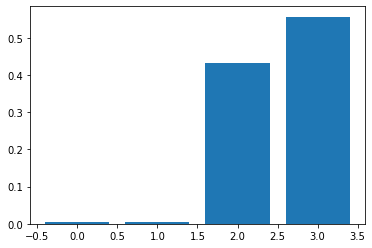

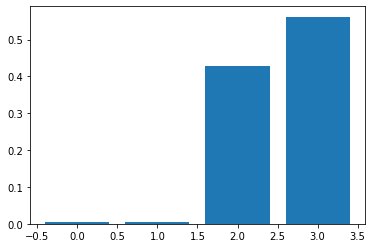

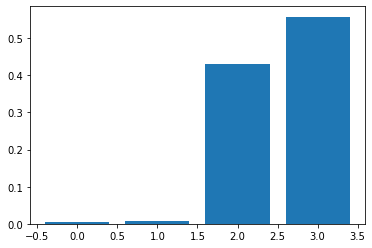

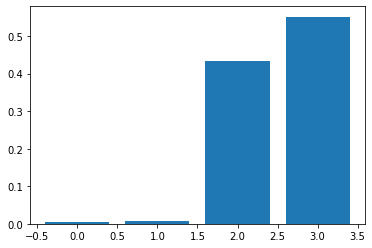

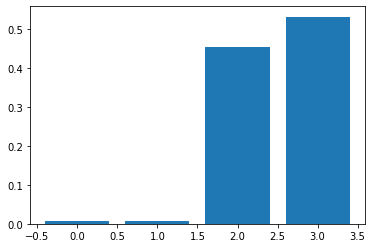

In [ ]:
generator_lr = 0.001
discriminator_lr = 0.0002

# Configure the GAN estimator with all the functions from above
gan_estimator = tfg.estimator.GANEstimator(generator_fn=quantum_generator_model,
                           discriminator_fn=discriminator_model,
                           generator_loss_fn=generator_loss_function,
                           discriminator_loss_fn=discriminator_loss_function,
                           generator_optimizer=tf.compat.v1.train.AdamOptimizer(generator_lr, 0.5),
                           discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
                           get_eval_metric_ops_fn=get_eval_metric_ops_fn)

steps_per_eval = 10 #@param
max_train_steps = 100 #@param
batches_for_eval_metrics = 10 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
zeros, ones, twos, threes = [],[],[],[]

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)
  gan_estimator.train(generate_data, max_steps=next_step)
  steps_taken = next_step - cur_step
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(generate_data, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  plt.figure()
  plt.bar(np.arange(0,4), [metrics['zeros'],metrics['ones'],metrics['twos'],metrics['threes']])
  zeros.append(metrics['zeros'])
  ones.append(metrics['ones'])
  twos.append(metrics['twos'])
  threes.append(metrics['threes'])
  print(metrics['entropy'])

plt.figure()
plt.plot(steps, zeros, steps, ones, steps, twos, steps, threes)
